# **INTRODUCTION**

Predicting the price of products is one of many busniness problems. In this report, I will analyse the data about one product and build a models to predict the price of this product.

Type of the problem: Regression

Data source: https://www.kaggle.com/danavg/abc-analysis-of-active-inventory/data?select=SalesKaggle3.csv

# **IMPORTING THE LIBRARIES**

Firstly, I will import some libraries and modules.

In [428]:
!pip install mpl-scatter-density

In [429]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.formula.api import ols
import mpl_scatter_density
from matplotlib.colors import LinearSegmentedColormap
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from scipy.special import boxcox1p

# **EXPLORING THE DATA**

Now, I will import the data set.  Below is some information I get from the data.

In [430]:
data = pd.read_csv("SalesKaggle3.csv")
data.head(10)

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice
0,2,Historical,1737127,0.0,0.0,D,15,1,682743.0,44.99,2015,8,28.97,31.84
1,3,Historical,3255963,0.0,0.0,D,7,1,1016014.0,24.81,2005,39,0.00,15.54
2,4,Historical,612701,0.0,0.0,D,0,0,340464.0,46.00,2013,34,30.19,27.97
3,6,Historical,115883,1.0,1.0,D,4,1,334011.0,100.00,2006,20,133.93,83.15
4,7,Historical,863939,1.0,1.0,D,2,1,1287938.0,121.95,2010,28,4.00,23.99
5,8,Historical,214948,0.0,0.0,D,0,0,1783153.0,132.00,2011,33,138.98,13.64
6,9,Historical,484059,0.0,0.0,D,13,1,2314801.0,95.95,2010,33,90.77,46.49
7,10,Historical,146401,0.0,0.0,D,4,1,721111.0,207.80,2011,57,187.90,30.56
8,11,Historical,110568,0.0,0.0,D,11,1,436667.0,119.81,2008,36,63.99,96.92
9,12,Historical,764270,0.0,0.0,D,5,1,6652211.0,49.95,2004,19,53.99,28.99


In [431]:
data.shape

(198917, 14)

The data set have 14 features and 198917 records.

In [432]:
data.dtypes

Order                 int64
File_Type            object
SKU_number            int64
SoldFlag            float64
SoldCount           float64
MarketingType        object
ReleaseNumber         int64
New_Release_Flag      int64
StrengthFactor      float64
PriceReg            float64
ReleaseYear           int64
ItemCount             int64
LowUserPrice        float64
LowNetPrice         float64
dtype: object

Then, I check type of each feature. We can see that there are 2 object features, the rest are numeric.

In [433]:
data.nunique()

Order               198917
File_Type                2
SKU_number          133360
SoldFlag                 2
SoldCount               37
MarketingType            2
ReleaseNumber           71
New_Release_Flag         2
StrengthFactor      197424
PriceReg             11627
ReleaseYear             85
ItemCount              501
LowUserPrice         12102
LowNetPrice          15403
dtype: int64

Checking number of unique values in each feature. The Order has 198917 unique values, that is equal to the number of records in the set. Therefore, I will drop this column.

In [434]:
data.drop(['Order'], inplace = True, axis = 1)

In [435]:
data.isnull().sum()

File_Type                0
SKU_number               0
SoldFlag            122921
SoldCount           122921
MarketingType            0
ReleaseNumber            0
New_Release_Flag         0
StrengthFactor           0
PriceReg                 0
ReleaseYear              0
ItemCount                0
LowUserPrice             0
LowNetPrice              0
dtype: int64

Then, I check NULL values. There are so many NULL values in *SoldFlag* and *SoldCount*. Their number of missing value is even the same. The rest don't have any NULL value. 

In [436]:
display(data.isnull().sum()/len(data))

File_Type           0.000000
SKU_number          0.000000
SoldFlag            0.617951
SoldCount           0.617951
MarketingType       0.000000
ReleaseNumber       0.000000
New_Release_Flag    0.000000
StrengthFactor      0.000000
PriceReg            0.000000
ReleaseYear         0.000000
ItemCount           0.000000
LowUserPrice        0.000000
LowNetPrice         0.000000
dtype: float64

The number of missing value in each column accounts for 61.8% of all. Therefore, I can not drop all NA values. I fill them by 0.

In [437]:
data.fillna(0, inplace = True)

In [438]:
data.describe(percentiles = [.1, .25, .5, .75, .995])

,SKU_number,SoldFlag,SoldCount,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice
count,1.989170e+05,198917.000000,198917.000000,198917.000000,198917.000000,1.989170e+05,198917.000000,198917.000000,198917.000000,198917.000000,198917.000000
mean,8.613626e+05,0.065334,0.123137,3.412202,0.642248,1.117115e+06,90.895243,2006.016414,41.426283,30.982487,46.832053
std,8.699794e+05,0.247115,0.739101,3.864243,0.479340,1.522090e+06,86.736367,9.158331,37.541215,69.066155,128.513236
min,5.000100e+04,0.000000,0.000000,0.000000,0.000000,6.275000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
10%,1.140020e+05,0.000000,0.000000,0.000000,0.000000,5.201720e+04,25.000000,1998.000000,15.000000,4.000000,9.500000
25%,2.172520e+05,0.000000,0.000000,1.000000,0.000000,1.614188e+05,42.000000,2003.000000,21.000000,4.910000,17.950000
50%,6.122080e+05,0.000000,0.000000,2.000000,1.000000,5.822240e+05,69.950000,2007.000000,32.000000,16.080000,33.980000
75%,9.047510e+05,0.000000,0.000000,5.000000,1.000000,1.430083e+06,116.000000,2011.000000,50.000000,40.240000,55.490000
99.5%,3.802163e+06,1.000000,4.000000,20.000000,1.000000,8.959059e+06,392.950000,2015.000000,222.000000,194.453000,308.044600
max,3.960788e+06,1.000000,73.000000,99.000000,1.000000,1.738445e+07,12671.480000,2018.000000,2542.000000,14140.210000,19138.790000


Now, Let's check the general information of the data set. We can see that some features have outliers. In a regression problem, outliers will interfere with the model leading to the accuracy of the model will be low. In order to solve this problem, I will drop outliers from the set.

In [439]:
data = data[data['SoldCount'] <= 10]
data = data[data['ReleaseYear'] >= 1900]
data = data[data['ReleaseNumber'] <= 20]
data = data[data['PriceReg'] <= 1000]
data = data[data['ItemCount'] <= 500]
data = data[data['LowUserPrice'] <= 500]
data = data[data['LowNetPrice'] <= 500]

The difference between values of ReleaseYear is too small compared to the values. So that, I will convert the year to the number of year till now.

In [440]:
data['ReleaseYear'] = 2022 - data['ReleaseYear']

# **VISUALIZATION**

Before visualizing the data, I will classify features into 2 groups: numeric and catagory. 

With numeric data, I use histogram to visualize. For the rest, I use barplot.

In [441]:
numeric = data.select_dtypes(exclude=object).columns
category = data.select_dtypes(include=object).columns

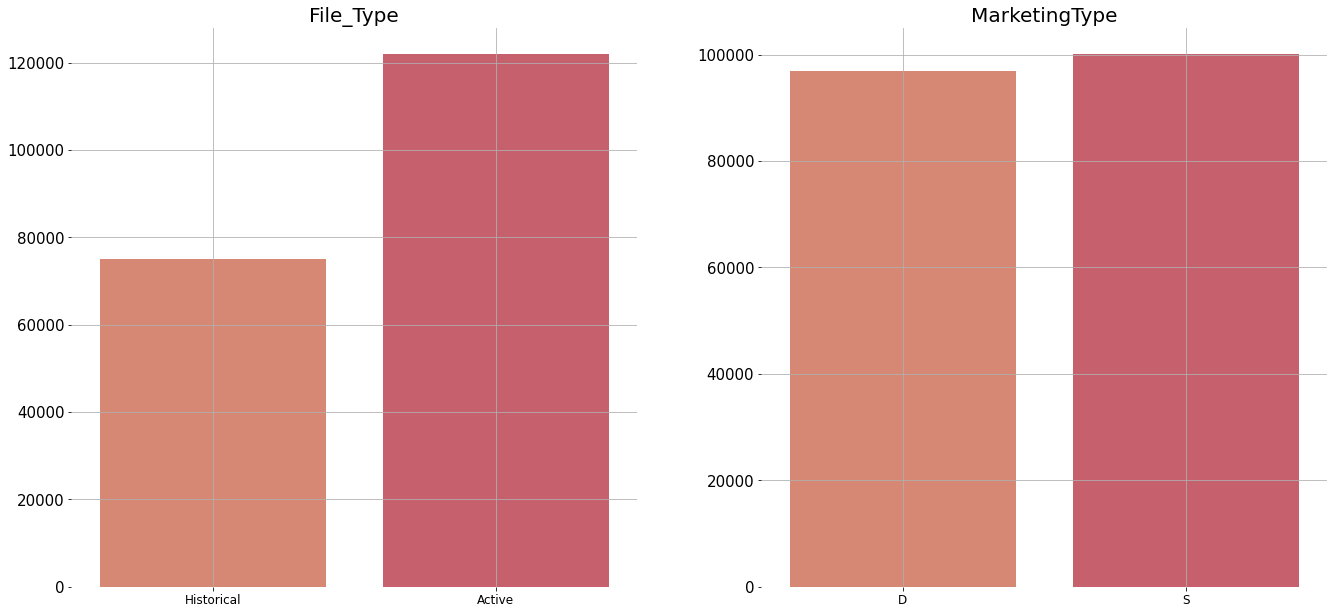

In [442]:
fig, ax = plt.subplots(figsize =(20, 10))
fig.patch.set_facecolor('white')
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 12
colors = sns.color_palette("flare", n_colors = 4).as_hex()
for i in (enumerate(category)):
  plt.subplot(1, 2, i[0]+1)
  sns.countplot(x = i[1], data = data, palette = colors, fill=True)
  plt.xlabel('')
  plt.ylabel('')
  plt.yticks(fontsize = 15, color='black')
  plt.box(False)
  plt.title(i[1], fontsize=20, color='black')
  plt.tight_layout(pad=5.0)
  plt.grid(b=None)

There are 2 barplots.


*   **File_Type**: The number of 'Active' is more than 'Historical'.
*   **MarketingType**: The ratio between type 'D' and type 'S' approx 1:1.



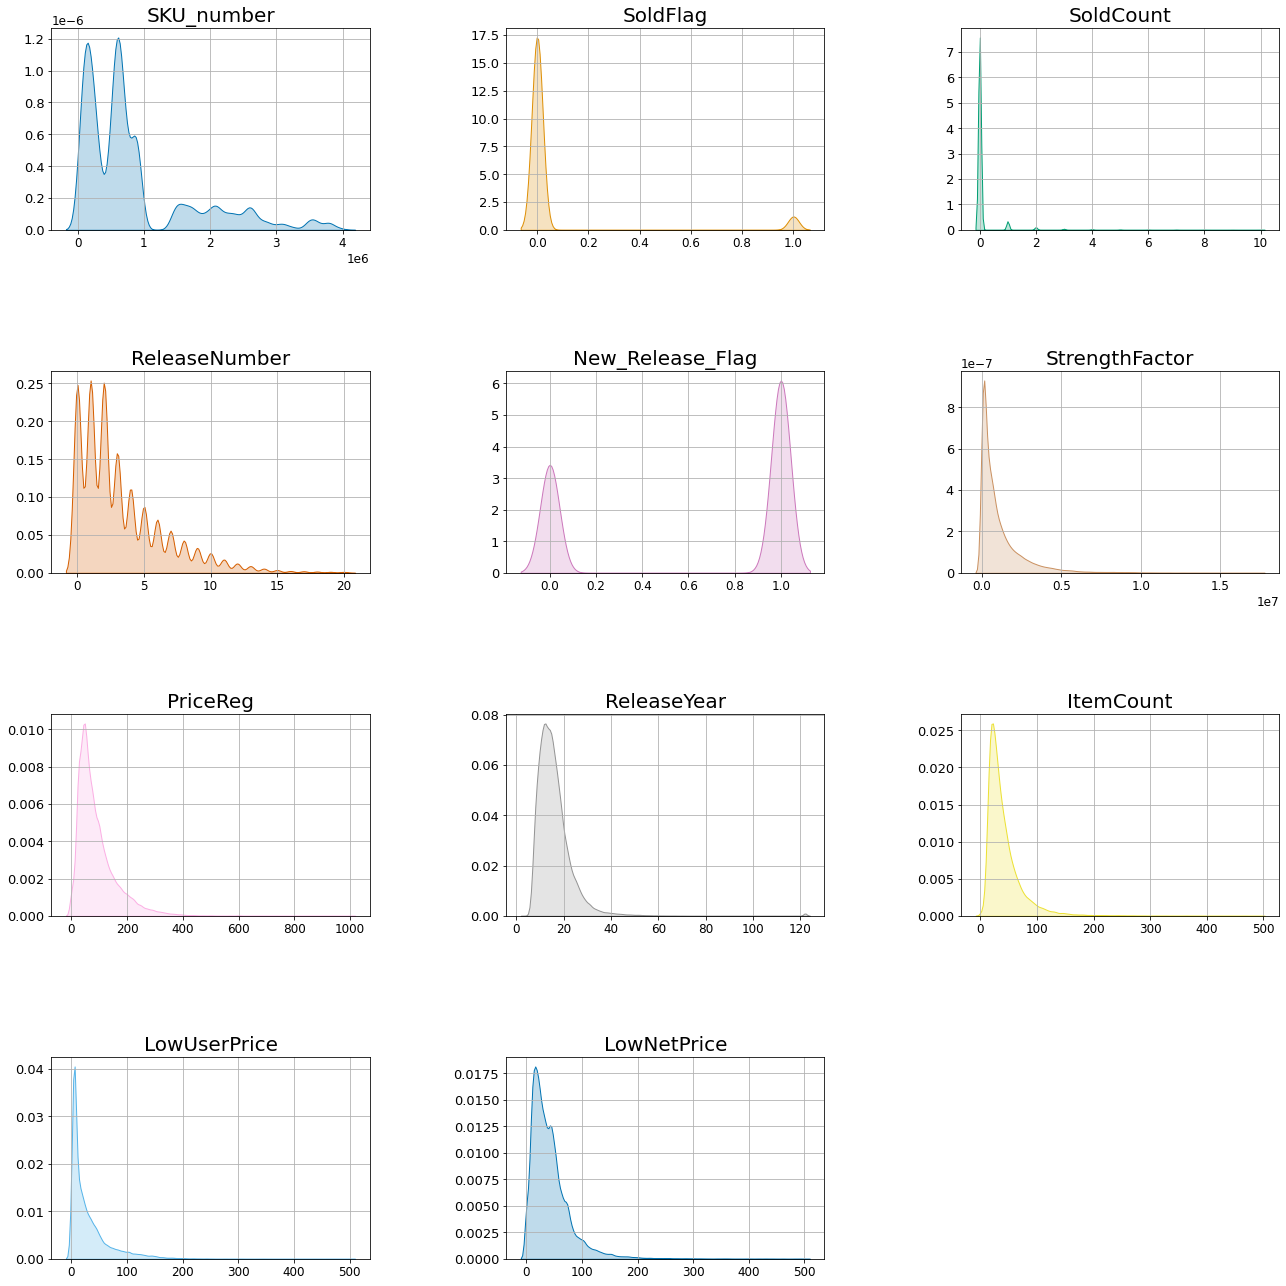

In [443]:
fig, ax = plt.subplots(figsize =(20, 20))
fig.patch.set_facecolor('white')
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 12

colors = sns.color_palette("colorblind", n_colors = 12).as_hex()

for i in (enumerate(numeric)):
    plt.subplot(4, 3, i[0]+1)
    sns.kdeplot(x = i[1], data = data, color = colors[i[0]], fill=True)
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks(fontsize=13, color='black')
    # plt.box(False)
    plt.title(i[1], fontsize=20, color='black')
    plt.tight_layout(pad=7.0)
    plt.grid(b=None)

There are 11 histograms. I will describe the main characteristics about them:


*   **SKU_number**: The histogram doesn't have normal distribution. This plot seems to be asymmetrical. 
*   **SoldFlag**: We can see from the plot that the number of type '0'is completely dominant over type '1'. 
*   **SoldCount**: The plot shows that there are so many values whose flags are '0'.
*   **ReleaseNumber**: We can easily see that the plot has the long-tail distribution with positive skew. Most values are from 0 to 2.
*   **New_Release_Flag**: There are 2 unique values: '0' and '1'. The number of '1' is more than twice the number of '0'.
*   **StrengthFactor**: This histogram has the long-tail distribution positive skew.
*   **PriceReg**: This plot has the long-tail distribution positive skew. Most of values is in range of 0 to 180.
*   **ReleaseYear**: This plot is quite symmetric with normal distribution. The peak is approximately 16.
*   **ItemCount**: The histogram has the symmetric distribution.
*   **LowUserPrice**: The plot seems to have the long-tail distribution.
*   **LowNetPrice**: The plot has the symmetric distribution and the peak is about 20.





In [444]:
feature_m2 = []
feature_l2 = []

for i in data.columns:
  if data[i].nunique() > 2:
    feature_m2.append(i)
  else:
    feature_l2.append(i)

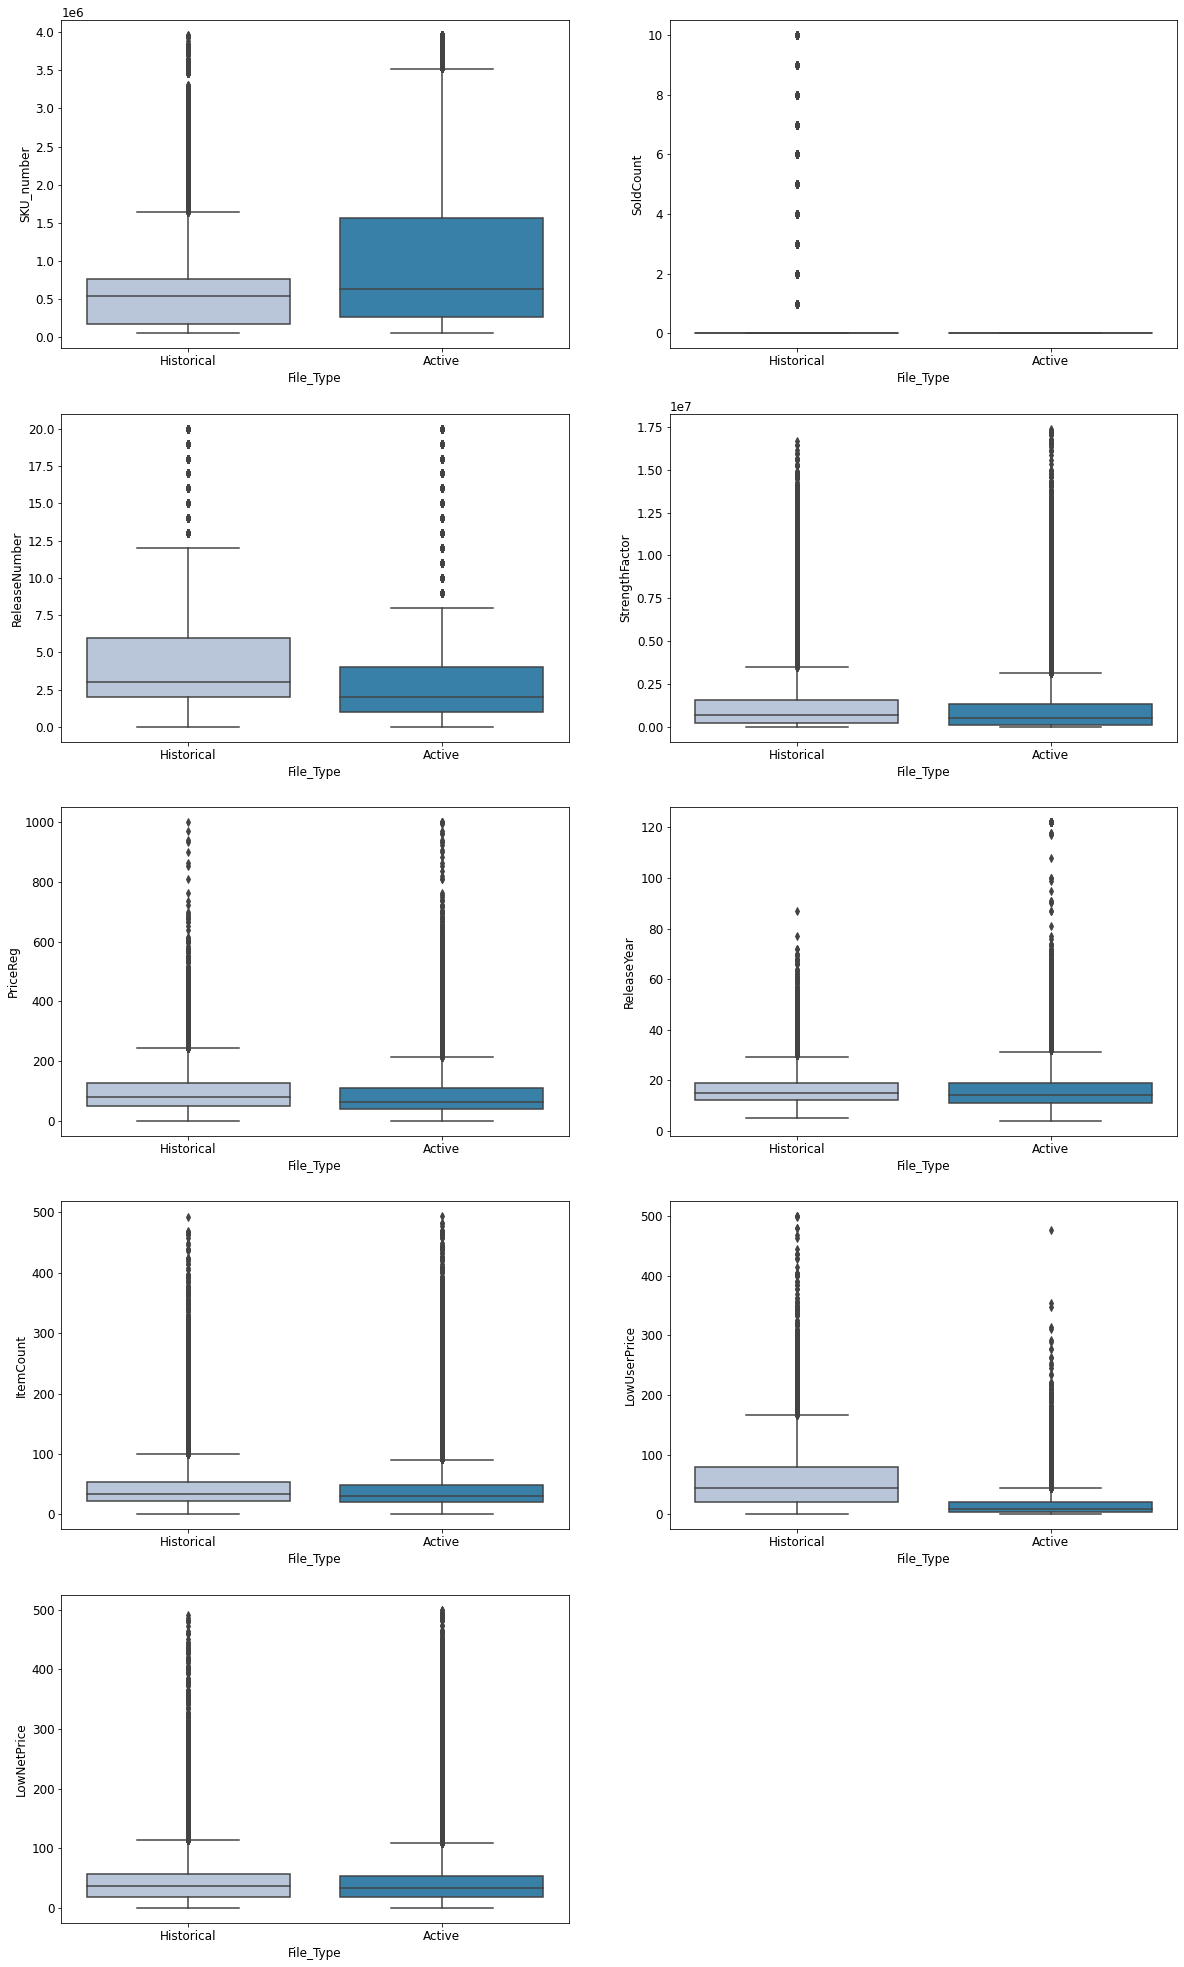

In [445]:
plt.figure(figsize=(20, 35))
a = 1
for i in feature_m2:
  if data[i].nunique() > 10:
    plt.subplot(5,2,a)
    sns.boxplot(data = data, x = 'File_Type', y = i, palette="PuBu")
    a = a+1

With features which have more than two unique values, I use violinplot to visualize the relationship between them and features which have only two unique values (*File_Type, SoldFlag, MarketingType, New_Release_Flag*)

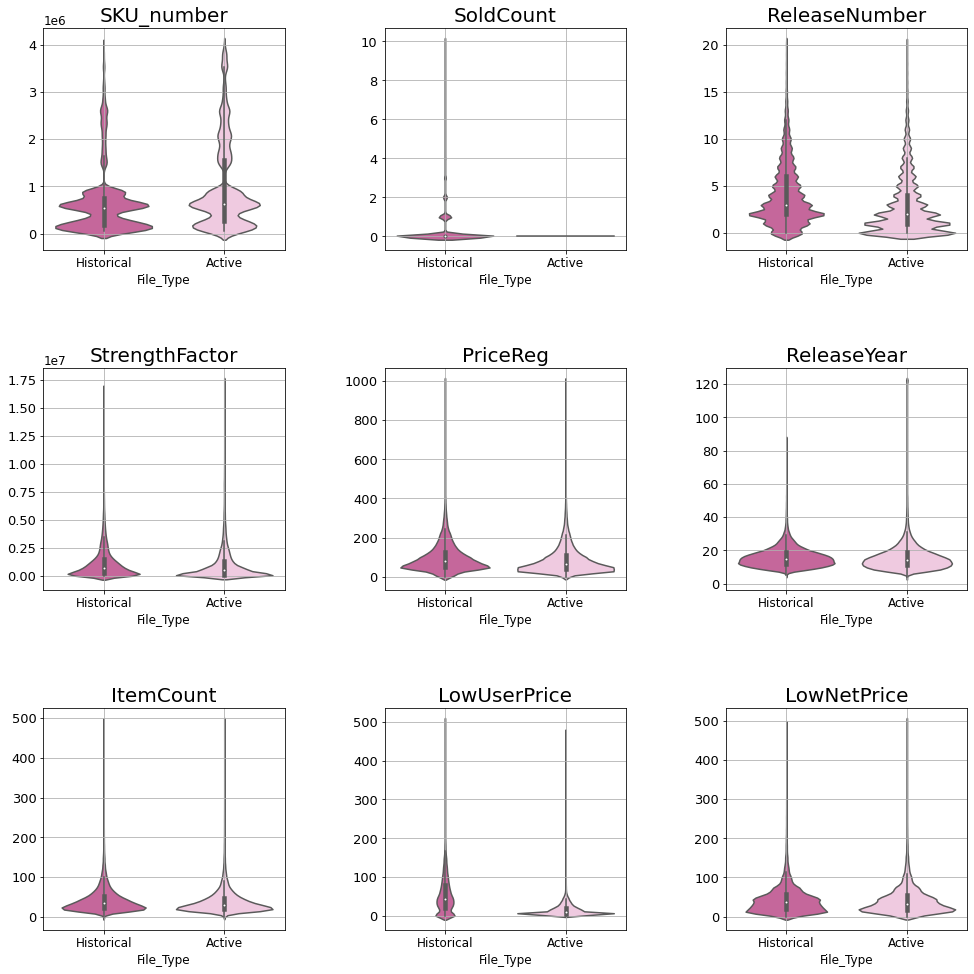

In [446]:
fig, ax = plt.subplots(figsize =(15, 15))
fig.patch.set_facecolor('white')
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 12
colors = sns.color_palette("PiYG", n_colors = 5).as_hex()

for i in (enumerate(feature_m2)):
    plt.subplot(3, 3, i[0]+1)
    sns.violinplot(x='File_Type', y=i[1], palette = colors, data=data)
    plt.xlabel('File_Type')
    plt.ylabel('')
    plt.yticks(fontsize=13, color='black')
    plt.title(i[1], fontsize=20, color='black')
    plt.tight_layout(pad=5.0)
    plt.grid(b=None)

From these plots, we can draw some conclusions as follows:


*   Some features have two similar distributed plots: *SKU_Number, StrengthFactor, PriceReg,...*
*   Some features have two great different distribution for two labels: *ReleaseNumber, LowUserPrice*





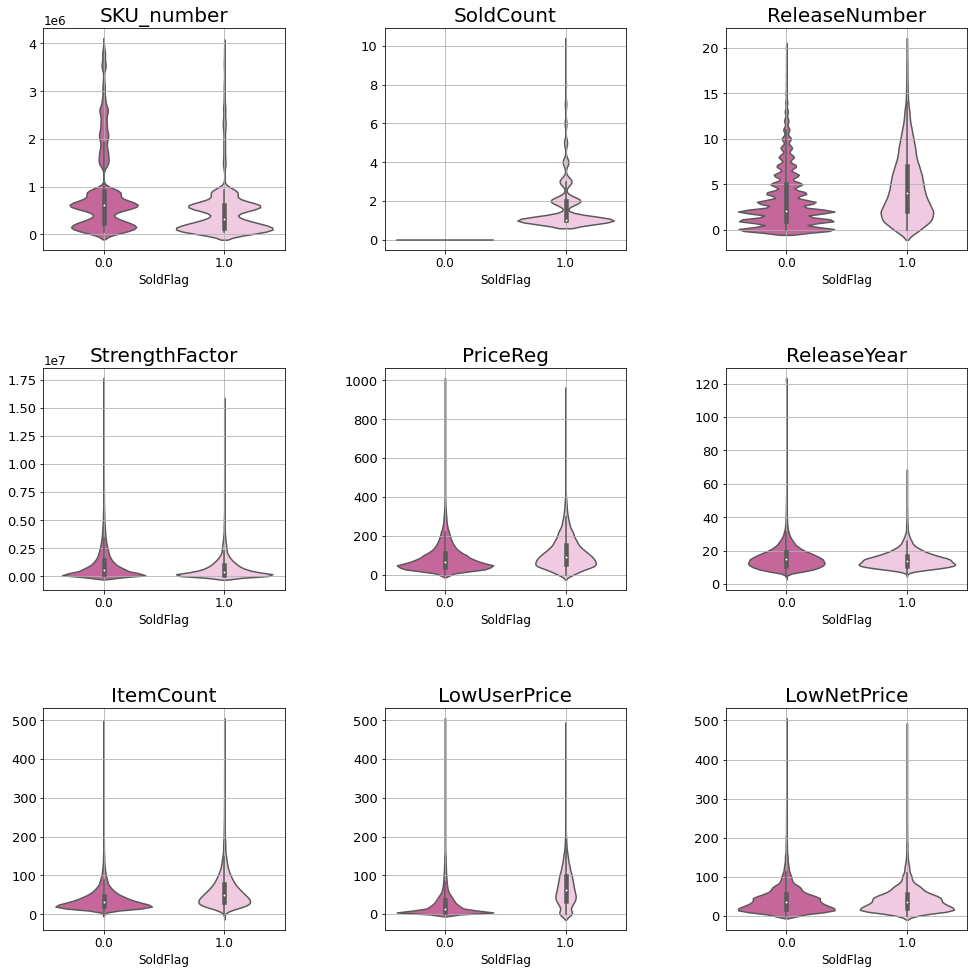

In [447]:
fig, ax = plt.subplots(figsize =(15, 15))
fig.patch.set_facecolor('white')
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 12
colors = sns.color_palette("PiYG", n_colors = 5).as_hex()

for i in (enumerate(feature_m2)):
    plt.subplot(3, 3, i[0]+1)
    sns.violinplot(x='SoldFlag', y=i[1], palette = colors, data=data)
    plt.xlabel('SoldFlag')
    plt.ylabel('')
    plt.yticks(fontsize=13, color='black')
    plt.title(i[1], fontsize=20, color='black')
    plt.tight_layout(pad=5.0)
    plt.grid(b=None)

*   Some features have two similar distributed plots: *SKU_Number, StrengthFactor, PriceReg,...*
*   Some features have two great different distribution for two labels: *SoldCount, ReleaseNumber, ItemCount, LowUserPrice*

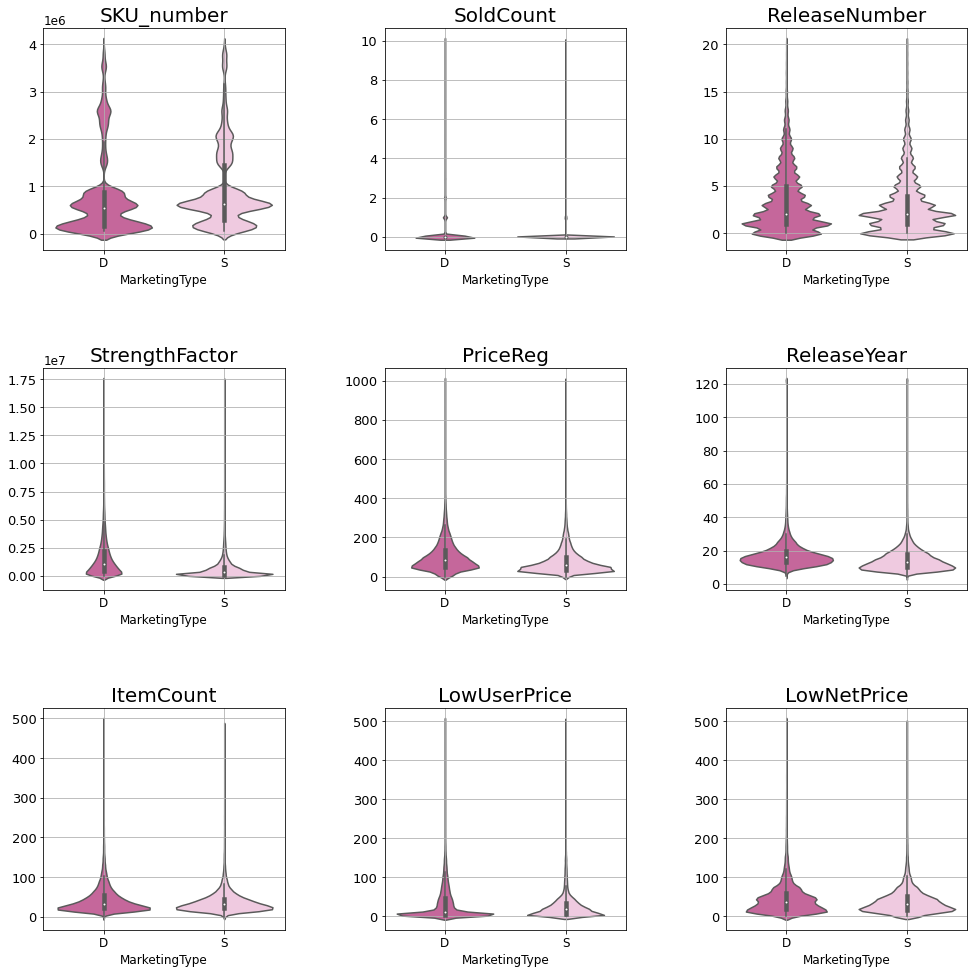

In [448]:
fig, ax = plt.subplots(figsize =(15, 15))
fig.patch.set_facecolor('white')
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 12
colors = sns.color_palette("PiYG", n_colors = 5).as_hex()

for i in (enumerate(feature_m2)):
    plt.subplot(3, 3, i[0]+1)
    sns.violinplot(x='MarketingType', y=i[1], palette = colors, data=data)
    plt.xlabel('MarketingType')
    plt.ylabel('')
    plt.yticks(fontsize=13, color='black')
    plt.title(i[1], fontsize=20, color='black')
    plt.tight_layout(pad=5.0)
    plt.grid(b=None)

*   Some features have two similar distributed plots: *SKU_Number, SoldCount, ReleaseNumber, PriceReg,...*
*   *StrengthFactor* plot has two great different distribution for two labels.

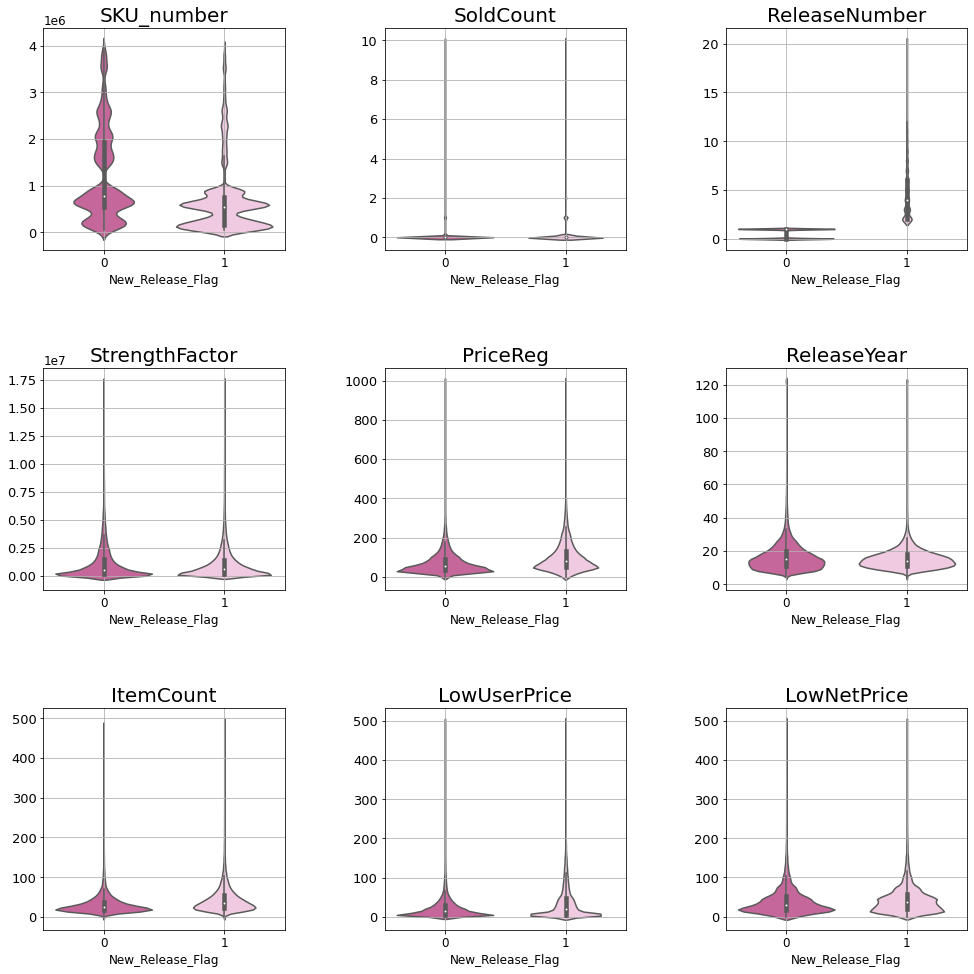

In [449]:
fig, ax = plt.subplots(figsize =(15, 15))
fig.patch.set_facecolor('white')
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 12
colors = sns.color_palette("PiYG", n_colors = 5).as_hex()

for i in (enumerate(feature_m2)):
    plt.subplot(3, 3, i[0]+1)
    sns.violinplot(x='New_Release_Flag', y=i[1], palette = colors, data=data)
    plt.xlabel('New_Release_Flag')
    plt.ylabel('')
    plt.yticks(fontsize=13, color='black')
    plt.title(i[1], fontsize=20, color='black')
    plt.tight_layout(pad=5.0)
    plt.grid(b=None)

*   Some features have two similar distributed plots: *SKU_Number, SoldCount, StrengthFactor,...*
*   *ReleaseNumber* plot has two great different distribution for two labels.

In order to process object data, I convert the category values to numeric values. 


*   **File_Type**: Replace 'Historical' by '0' and 'Active' by 1.
*   **MarketingType**: Replace 'D' by '0' and 'S' by '1'.



In [450]:
data['File_Type'] = data['File_Type'].replace('Historical', 0)
data['File_Type'] = data['File_Type'].replace('Active', 1)
data['MarketingType'] = data['MarketingType'].replace('D', 0)
data['MarketingType'] = data['MarketingType'].replace('S', 1)

After that, I use heatmap plot to visualize the correlation betweens features. If a block has a dark green color, it means that two corresponding features are quite proportional. Conversely, if a block has a dark orange color, it means that two corresponding features are inversely proportional. If the block has a light color, two features may be not related.

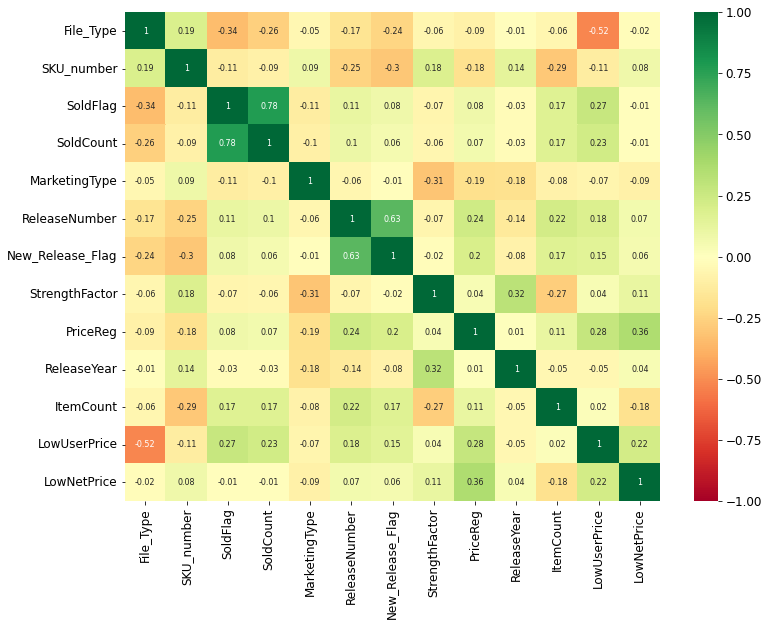

In [451]:
plt.figure(figsize=(12,9))
correlations = data.corr()
sns.heatmap(round(correlations,2), cmap='RdYlGn', annot=True, 
            annot_kws={"size": 8}, vmin=-1, vmax=1);

Checking skew of features, we can see some features are extremely asymmetric. I will use Boxcox to normalize them.

In [452]:
data.agg(['skew', 'kurtosis']).transpose()

,skew,kurtosis
File_Type,-0.489184,-1.760717
SKU_number,1.554298,1.721939
SoldFlag,3.538248,10.519306
SoldCount,7.809434,82.341814
MarketingType,-0.031082,-1.999054
ReleaseNumber,1.525439,2.649137
New_Release_Flag,-0.585051,-1.657733
StrengthFactor,2.984790,12.938704
PriceReg,2.124292,8.392331
ReleaseYear,5.116494,55.594401


In [454]:
data["ReleaseYear"], l1 = boxcox(data["ReleaseYear"])
data["SoldCount"] = boxcox1p(data["SoldCount"], 0.01)

# **PCA**

I use ANOVA-Test to find features that is important to build the model. I choose 8 best features (which have the least PR(>F)).

In [457]:
iris_lm=ols('PriceReg ~  File_Type + SKU_number + SoldFlag + SoldCount + MarketingType + ReleaseNumber + New_Release_Flag + StrengthFactor + ReleaseYear + ItemCount + LowUserPrice + LowNetPrice', data=data).fit() 
a = sm.stats.anova_lm(iris_lm, typ=2)

In [458]:
a = a.sort_values(by='PR(>F)')
b = a.head(8)
b

,sum_sq,df,F,PR(>F)
SKU_number,1.210377e+07,1.0,3182.787585,0.000000e+00
MarketingType,8.984444e+06,1.0,2362.535676,0.000000e+00
ReleaseNumber,7.644962e+06,1.0,2010.307425,0.000000e+00
ItemCount,6.587570e+06,1.0,1732.257163,0.000000e+00
LowUserPrice,2.688358e+07,1.0,7069.266092,0.000000e+00
LowNetPrice,9.322117e+07,1.0,24513.295903,0.000000e+00
File_Type,3.619917e+06,1.0,951.887792,1.626584e-208
ReleaseYear,1.051633e+06,1.0,276.535732,4.709272e-62


# **BUILDING THE MODEL**

## **Splitting the data**

I split the data set into 2 parts: training data 80% and validation data 20%.

In [459]:
features = b.index

In [460]:
y = np.array(data['PriceReg']).T

In [461]:
X = np.array(pd.DataFrame(data, columns = features))

In [462]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=15)

## **Linear Regression**

Using Linear Regression:

In [463]:
LR = LinearRegression(fit_intercept = False)
LR.fit(X_train,y_train)
predictions = LR.predict(X_test)

Root mean squared error:

In [464]:
#RMSE
mean_squared_error(y_test, predictions, squared=False)

61.323622256998995

Coefficient of determination:

In [465]:
r2_score(y_test, predictions)

0.26510824573802316

/usr/local/lib/python3.7/dist-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.7/dist-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



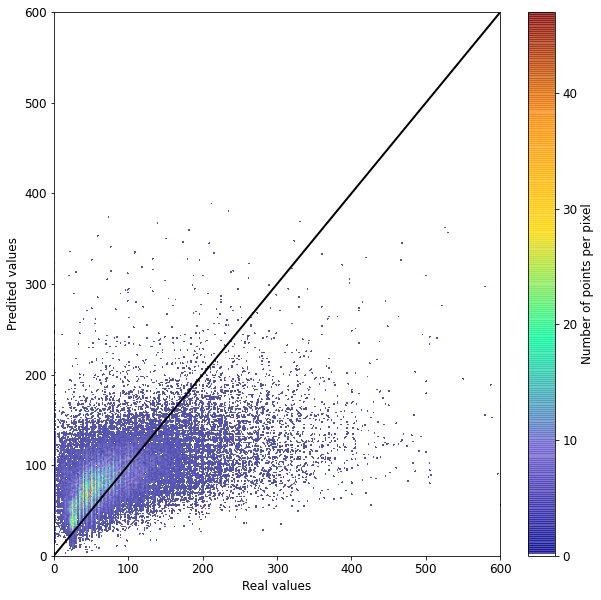

In [467]:
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, 'darkblue'),
    (0.2, 'slateblue'),
    (0.4, 'mediumspringgreen'),
    (0.6, 'gold'),
    (0.8, 'darkorange'),
    (1, 'maroon'),
], N=256)

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis, alpha=0.7)
    fig.colorbar(density, label='Number of points per pixel')
fig = plt.figure(figsize=(10, 10))
using_mpl_scatter_density(fig, y_test, predictions)
fig1 = plt.subplot(1, 1, 1)
fig1.set_xlim([0, 600])
fig1.set_ylim([0, 600])
xpoints = ypoints = plt.xlim()
fig1.plot(xpoints, ypoints, linestyle='-', color='k', lw=2, scalex=False, scaley=False)
fig1.set_xlabel('Real values')
fig1.set_ylabel('Predited values')
plt.show()

## **Ridge Regression**

Using Ridge Regression:

In [468]:
RR = Ridge(alpha=1.0, tol = 5e-4, random_state = 20)
RR.fit(X_train,y_train)
prediction2 = RR.predict(X_test)

Root mean squared error:

In [469]:
#RMSE
mean_squared_error(y_test, prediction2, squared=False)

61.31954885586274

Coefficient of determination:

In [470]:
r2_score(y_test, prediction2)

0.26520587237439086

/usr/local/lib/python3.7/dist-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.7/dist-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



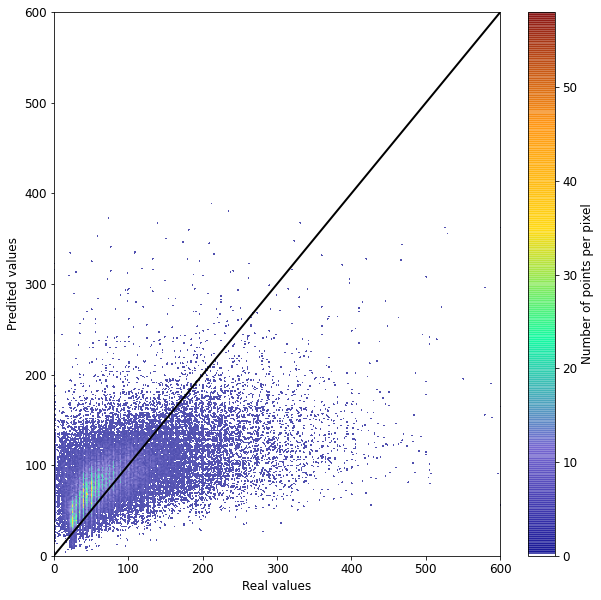

In [471]:
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, 'darkblue'),
    (0.2, 'slateblue'),
    (0.4, 'mediumspringgreen'),
    (0.6, 'gold'),
    (0.8, 'darkorange'),
    (1, 'maroon'),
], N=256)

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis, alpha=0.7)
    fig.colorbar(density, label='Number of points per pixel')
fig = plt.figure(figsize=(10, 10))
using_mpl_scatter_density(fig, y_test, prediction2)
fig1 = plt.subplot(1, 1, 1)
fig1.set_xlim([0, 600])
fig1.set_ylim([0, 600])
xpoints = ypoints = plt.xlim()
fig1.plot(xpoints, ypoints, linestyle='-', color='k', lw=2, scalex=False, scaley=False)
fig1.set_xlabel('Real values')
fig1.set_ylabel('Predited values')
plt.show()

In [472]:
perer = abs(y_test - prediction2)*100/y_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in true_divide



In [473]:
Percentage = np.ma.masked_invalid(perer)

In [493]:
fig = go.Figure(go.Histogram(
    x=Percentage,
    bingroup=1,
    xbins=dict(
        start=-3.0,
        end=300,
        size=1
    ),
    marker_color='#330C73'))
fig.update_layout(
    title_text='Percentage of the difference between  predicted values and real values.')
fig.show()

## **Polynomial Regression**

In [475]:
Poly = PolynomialFeatures(2)

In [476]:
# Poly.fit(X_train, y_train)
X_ = Poly.fit_transform(X_train)
X1_ = Poly.fit_transform(X_test)

In [477]:
clf = LinearRegression()
clf.fit(X_, y_train)
predict_ = clf.predict(X1_)

Root mean squared error (the best in 3 models):

In [478]:
mean_squared_error(y_test, predict_, squared=False)

59.34604095543981

Coefficient of determination:

In [479]:
r2_score(y_test, predict_)

0.3117419831133532

/usr/local/lib/python3.7/dist-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.7/dist-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



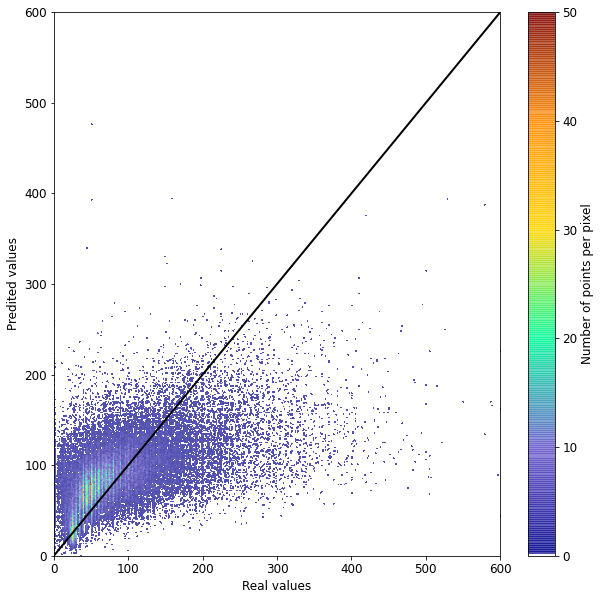

In [480]:
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, 'darkblue'),
    (0.2, 'slateblue'),
    (0.4, 'mediumspringgreen'),
    (0.6, 'gold'),
    (0.8, 'darkorange'),
    (1, 'maroon'),
], N=256)

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis, alpha=0.7)
    fig.colorbar(density, label='Number of points per pixel')
fig = plt.figure(figsize=(10, 10))
using_mpl_scatter_density(fig, y_test, predict_)
fig1 = plt.subplot(1, 1, 1)
fig1.set_xlim([0, 600])
fig1.set_ylim([0, 600])
xpoints = ypoints = plt.xlim()
fig1.plot(xpoints, ypoints, linestyle='-', color='k', lw=2, scalex=False, scaley=False)
fig1.set_xlabel('Real values')
fig1.set_ylabel('Predited values')
plt.show()

## **Gradient Descent**

Using Gradient Descent for Linear Regression model:

In [481]:
W = LR.coef_
b = LR.intercept_ # equal to 0

In [482]:
def grad(y, W, X):
  return np.sum(X.T * (np.sum(W.T*X, axis = 1) - y) / y.size, axis = 1)

def cost(y, W, X):
  return .5* np.linalg.norm(y - np.sum(W.T*X, axis = 1) - b)**2 /y_test.size 

# cost(y_test, X_test)

In [483]:
def GD(w_init, eta,b):
  w = [w_init]
  c = cost(y_test, w_init, X_test)
  ans = w
  for it in range(1000):
    g = grad(y_test, w[-1], X_test)
    w_new = w[-1] - 1e-12*g
    if cost(y_test, w_new, X_test) < c:
      ans = w_new
      c = cost(y_test, w_new, X_test)
      break
    w.append(w_new)
  return ans


In [484]:
w1 = GD(W, 1e-12,b)


Root mean squared error (reduce a little bit):

In [487]:
mean_squared_error(y_test, np.sum(w1.T*X_test, axis = 1), squared=False)

61.32267098954147

Coefficient of determination:

In [488]:
r2_score(y_test, np.sum(w1.T*X_test, axis = 1))

0.2651310452127691